In [5]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
main_df = pd.read_pickle('main_df_sampled.pickle')
# main_df = main_df.sample(10000)

In [7]:
main_df

,id,subreddit,title,selftext,genre
0,4ra2z6,Throwers,new to this (vibrations),"""i recently got back into yoyos last time i ha...",hobby
1,6dkhwl,weddingplanning,vendor and photographer issues and frustrations,"""your stories and advice are most certainly we...",sex/relationships
2,5jzfbj,redditdev,[praw 360] test if comment is top level ? or ...,"""i mod a sub that is looking into adding a rul...",meta
3,6680x8,csshelp,in /r/modern_hp_theme (a test subreddit) how c...,"""/r/modern_hp_theme space:nowrap;color:#666...",programming
4,4tadox,StrangerThings,mr wheeler stole every scene he was in,"""""""what did i do ? what did iiiiiiiii doooooo...",tv_show
...,...,...,...,...,...
116995,6cum56,LearnJapanese,i'm having trouble reading the number 七十一万四千 w...,what throws me off is the 七十一 at the beginning...,education
116996,6dud8e,HotPeppers,my reaper seeds won't sprout,i'm using the damp towel in plastic bag method...,food/drink
116997,4nyacs,Warmachine,what happened to skorne ?,"""so i have no idea what happened to other fact...",board_game
116998,66y8wp,TalesFromThePizzaGuy,"""""""ma'am i know you're lying right now enjoy y...","""last week we were stupid slow all day and thi...",writing/stories


In [8]:
text_df = main_df['title'].map(str) + " " + main_df['selftext']

In [9]:
# Calculate the number of words in each string
word_counts = [len(sentence.split()) for sentence in text_df]

# Calculate the median number of words
median_word_count = np.median(word_counts)

median_word_count

69.0

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.optimizers import Adam

EMBEDDING_DIM = 300  # Embedding dimension
MAX_SEQUENCE_LENGTH = int(median_word_count)  # Maximum sequence length
NUM_FILTERS = 64
KERNEL_SIZE = 3

model = Sequential()
model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, activation='relu', input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)))
model.add(MaxPooling1D(pool_size=2))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(EMBEDDING_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(39, activation='softmax'))

In [11]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [12]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

preprocessed = [simple_preprocess(x) for x in tqdm(main_df['title'] + " " + main_df['selftext'])]
word2vec_model = Word2Vec(sentences=preprocessed, vector_size=300, window=5, min_count=1, workers=4)

<ipython-input-12-abcb8d0c2cfb>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  preprocessed = [simple_preprocess(x) for x in tqdm(main_df['title'] + " " + main_df['selftext'])]


  0%|          | 0/117000 [00:00<?, ?it/s]

In [13]:
import torch
from transformers import BertModel, BertTokenizer
import os
import gc
import pickle


def generate_word2vec_embeddings(text, max_length=MAX_SEQUENCE_LENGTH):
    # Tokenize the text using simple_preprocess
    tokens = simple_preprocess(text)

    # Initialize an empty array to store the embeddings
    embeddings = []

    # For each token in the text
    for token in tokens:
        try:
            # Get the Word2Vec embedding for the token
            embedding = word2vec_model.wv[token]
            embeddings.append(embedding)
        except KeyError:
            # If the token is not in the vocabulary, ignore it
            pass

    # Check if embeddings list is empty or shorter than max_length
    if not embeddings:
        return np.zeros((max_length, word2vec_model.vector_size))  # Return zeros if no embeddings
    elif len(embeddings) < max_length:
        # Pad the embeddings with zeros
        padding = [np.zeros_like(embeddings[0])] * (max_length - len(embeddings))
        embeddings.extend(padding)
    elif len(embeddings) > max_length:
        # Truncate the embeddings
        embeddings = embeddings[:max_length]

    # Convert the embeddings list to a NumPy array
    embeddings_array = np.array(embeddings)

    return embeddings_array

def train_lstm_cnn(main_df_sampled, index):
  if os.path.exists(f"/content/drive/MyDrive/cs256trainingdata/X_{index}") and os.path.exists(f"/content/drive/MyDrive/cs256trainingdata/Y_{index}"):
    with open(f"/content/drive/MyDrive/cs256trainingdata/X_{index}", 'rb') as f:
      X_word2vec = pickle.load(f)
    with open(f"/content/drive/MyDrive/cs256trainingdata/Y_{index}", 'rb') as f:
      Y = pickle.load(f)
  else:
    print("asf")
    text_df = main_df_sampled['title'].map(str) + " " + main_df_sampled['selftext']
    text_df_fixed = []
    for sentence in text_df:
        words = sentence.split()
        if len(words) > median_word_count:
            words = words[:int(median_word_count)]
        modified_sentence = ' '.join(words).strip()
        text_df_fixed.append(modified_sentence)
    X_word2vec = []
    for i in tqdm(range(len(text_df_fixed))):
      X_word2vec.append(generate_word2vec_embeddings(text_df_fixed[i]))
    X_word2vec = np.array(X_word2vec)
    Y = pd.get_dummies(main_df_sampled['genre'].values)
    with open(f"/content/drive/MyDrive/cs256trainingdata/X_{index}", 'wb') as f:
      pickle.dump(X_word2vec, f)
    with open(f"/content/drive/MyDrive/cs256trainingdata/Y_{index}", 'wb') as f:
      pickle.dump(Y, f)

  history = model.fit(X_word2vec, Y, batch_size=64, epochs=1)
  del X_word2vec, Y
  gc.collect()

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
batch_size = 200
num_batches = 15


import tensorflow as tf

# Check if a GPU is available and set the device accordingly
if tf.test.gpu_device_name():
    print('GPU found')
    device = '/device:GPU:0'  # Use the first GPU
else:
    print('No GPU found')
    device = '/device:CPU:0'


for epoch in range(10):
  main_df_copy = main_df.copy()
  print("Epoch: ", epoch)
  for i in range(int(0.8*num_batches)):
      sampled_data = []
      for genre in main_df['genre'].unique():
          genre_data = main_df_copy[main_df_copy['genre'] == genre].sample(n=batch_size, random_state=42)
          sampled_data.append(genre_data)
          main_df_copy.drop(genre_data.index, inplace=True)

      batch_data = pd.concat(sampled_data)

      batch_data = batch_data.sample(frac=1, random_state=42).reset_index(drop=True)

      print("Processing Batch:", i+1)


      main_df_sampled = batch_data
      index = i

      if os.path.exists(f"/content/drive/MyDrive/cs256trainingdata/X_{index}") and os.path.exists(f"/content/drive/MyDrive/cs256trainingdata/Y_{index}"):
        with open(f"/content/drive/MyDrive/cs256trainingdata/X_{index}", 'rb') as f:
          X_word2vec = pickle.load(f)
        with open(f"/content/drive/MyDrive/cs256trainingdata/Y_{index}", 'rb') as f:
          Y = pickle.load(f)
      else:
        print("asf")
        text_df = main_df_sampled['title'].map(str) + " " + main_df_sampled['selftext']
        text_df_fixed = []
        for sentence in text_df:
            words = sentence.split()
            if len(words) > median_word_count:
                words = words[:int(median_word_count)]
            modified_sentence = ' '.join(words).strip()
            text_df_fixed.append(modified_sentence)
        X_word2vec = []
        for i in tqdm(range(len(text_df_fixed))):
          X_word2vec.append(generate_word2vec_embeddings(text_df_fixed[i]))
        X_word2vec = np.array(X_word2vec)
        Y = pd.get_dummies(main_df_sampled['genre'].values)
        with open(f"/content/drive/MyDrive/cs256trainingdata/X_{index}", 'wb') as f:
          pickle.dump(X_word2vec, f)
        with open(f"/content/drive/MyDrive/cs256trainingdata/Y_{index}", 'wb') as f:
          pickle.dump(Y, f)

      m = None
      # Use `with tf.device(device):` to scope operations to the specified device
      with tf.device(device):
          history = model.fit(X_word2vec, Y, batch_size=64, epochs=1)
          del X_word2vec, Y
          gc.collect()

  model.save(f"/content/drive/MyDrive/cs256models/model_epoch_{epoch}.h5")

No GPU found
Epoch:  0
Processing Batch: 1
122/122 [==============================] - 64s 489ms/step - loss: 3.5336 - accuracy: 0.0581
Processing Batch: 2
122/122 [==============================] - 53s 431ms/step - loss: 3.2212 - accuracy: 0.1119
Processing Batch: 3
122/122 [==============================] - 49s 402ms/step - loss: 3.0252 - accuracy: 0.1429
Processing Batch: 4
asf


<ipython-input-15-8f0193ba64b3>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(text_df_fixed))):


  0%|          | 0/7800 [00:00<?, ?it/s]

122/122 [==============================] - 55s 448ms/step - loss: 2.9475 - accuracy: 0.1664
Processing Batch: 5
asf


<ipython-input-15-8f0193ba64b3>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(text_df_fixed))):


  0%|          | 0/7800 [00:00<?, ?it/s]

122/122 [==============================] - 57s 471ms/step - loss: 2.8312 - accuracy: 0.1991
Processing Batch: 6
asf


<ipython-input-15-8f0193ba64b3>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(text_df_fixed))):


  0%|          | 0/7800 [00:00<?, ?it/s]

122/122 [==============================] - 53s 437ms/step - loss: 2.7615 - accuracy: 0.2101
Processing Batch: 7
asf


<ipython-input-15-8f0193ba64b3>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(text_df_fixed))):


  0%|          | 0/7800 [00:00<?, ?it/s]

122/122 [==============================] - 56s 457ms/step - loss: 2.7043 - accuracy: 0.2335
Processing Batch: 8
asf


<ipython-input-15-8f0193ba64b3>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(text_df_fixed))):


  0%|          | 0/7800 [00:00<?, ?it/s]

122/122 [==============================] - 53s 436ms/step - loss: 2.6372 - accuracy: 0.2509
Processing Batch: 9
asf


<ipython-input-15-8f0193ba64b3>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(text_df_fixed))):


  0%|          | 0/7800 [00:00<?, ?it/s]

122/122 [==============================] - 52s 423ms/step - loss: 2.6235 - accuracy: 0.2586
Processing Batch: 10
asf


<ipython-input-15-8f0193ba64b3>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(text_df_fixed))):


  0%|          | 0/7800 [00:00<?, ?it/s]

122/122 [==============================] - 54s 442ms/step - loss: 2.5886 - accuracy: 0.2713
Processing Batch: 11
asf


<ipython-input-15-8f0193ba64b3>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(text_df_fixed))):


  0%|          | 0/7800 [00:00<?, ?it/s]

122/122 [==============================] - 56s 459ms/step - loss: 2.5635 - accuracy: 0.2821
Processing Batch: 12
asf


<ipython-input-15-8f0193ba64b3>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(text_df_fixed))):


  0%|          | 0/7800 [00:00<?, ?it/s]

122/122 [==============================] - 52s 428ms/step - loss: 2.5476 - accuracy: 0.2824


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  1
Processing Batch: 1
122/122 [==============================] - 53s 433ms/step - loss: 2.5753 - accuracy: 0.2694
Processing Batch: 2
122/122 [==============================] - 52s 430ms/step - loss: 2.5434 - accuracy: 0.2844
Processing Batch: 3
122/122 [==============================] - 52s 424ms/step - loss: 2.5081 - accuracy: 0.2874
Processing Batch: 4
122/122 [==============================] - 55s 449ms/step - loss: 2.4490 - accuracy: 0.3129
Processing Batch: 5
122/122 [==============================] - 53s 435ms/step - loss: 2.4257 - accuracy: 0.3163
Processing Batch: 6
122/122 [==============================] - 52s 424ms/step - loss: 2.3975 - accuracy: 0.3258
Processing Batch: 7
122/122 [==============================] - 54s 440ms/step - loss: 2.3681 - accuracy: 0.3295
Processing Batch: 8
122/122 [==============================] - 50s 413ms/step - loss: 2.3438 - accuracy: 0.3381
Processing Batch: 9
122/122 [==============================] - 58s 472ms/step - loss: 2.3656 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  2
Processing Batch: 1
122/122 [==============================] - 51s 423ms/step - loss: 2.3578 - accuracy: 0.3246
Processing Batch: 2
122/122 [==============================] - 52s 423ms/step - loss: 2.3442 - accuracy: 0.3331
Processing Batch: 3
122/122 [==============================] - 50s 411ms/step - loss: 2.3505 - accuracy: 0.3373
Processing Batch: 4
122/122 [==============================] - 60s 494ms/step - loss: 2.2668 - accuracy: 0.3628
Processing Batch: 5
122/122 [==============================] - 51s 421ms/step - loss: 2.2535 - accuracy: 0.3642
Processing Batch: 6
122/122 [==============================] - 51s 421ms/step - loss: 2.2506 - accuracy: 0.3533
Processing Batch: 7
122/122 [==============================] - 50s 407ms/step - loss: 2.2105 - accuracy: 0.3733
Processing Batch: 8
122/122 [==============================] - 50s 408ms/step - loss: 2.2027 - accuracy: 0.3806
Processing Batch: 9
122/122 [==============================] - 50s 410ms/step - loss: 2.2186 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  3
Processing Batch: 1
122/122 [==============================] - 53s 434ms/step - loss: 2.2426 - accuracy: 0.3610
Processing Batch: 2
122/122 [==============================] - 52s 428ms/step - loss: 2.2515 - accuracy: 0.3618
Processing Batch: 3
122/122 [==============================] - 52s 426ms/step - loss: 2.2455 - accuracy: 0.3594
Processing Batch: 4
122/122 [==============================] - 52s 423ms/step - loss: 2.1713 - accuracy: 0.3869
Processing Batch: 5
122/122 [==============================] - 52s 428ms/step - loss: 2.1557 - accuracy: 0.3864
Processing Batch: 6
122/122 [==============================] - 53s 433ms/step - loss: 2.1541 - accuracy: 0.3800
Processing Batch: 7
122/122 [==============================] - 54s 443ms/step - loss: 2.1360 - accuracy: 0.3956
Processing Batch: 8
122/122 [==============================] - 50s 412ms/step - loss: 2.1145 - accuracy: 0.3994
Processing Batch: 9
122/122 [==============================] - 52s 423ms/step - loss: 2.1230 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  4
Processing Batch: 1
122/122 [==============================] - 52s 427ms/step - loss: 2.1594 - accuracy: 0.3823
Processing Batch: 2
122/122 [==============================] - 54s 442ms/step - loss: 2.1775 - accuracy: 0.3773
Processing Batch: 3
122/122 [==============================] - 52s 429ms/step - loss: 2.1657 - accuracy: 0.3846
Processing Batch: 4
122/122 [==============================] - 59s 487ms/step - loss: 2.1019 - accuracy: 0.4019
Processing Batch: 5
122/122 [==============================] - 52s 427ms/step - loss: 2.0717 - accuracy: 0.4103
Processing Batch: 6
122/122 [==============================] - 52s 430ms/step - loss: 2.0843 - accuracy: 0.4023
Processing Batch: 7
122/122 [==============================] - 52s 425ms/step - loss: 2.0578 - accuracy: 0.4149
Processing Batch: 8
122/122 [==============================] - 54s 442ms/step - loss: 2.0458 - accuracy: 0.4173
Processing Batch: 9
122/122 [==============================] - 52s 423ms/step - loss: 2.0574 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  5
Processing Batch: 1
122/122 [==============================] - 51s 420ms/step - loss: 2.0950 - accuracy: 0.4036
Processing Batch: 2
122/122 [==============================] - 53s 433ms/step - loss: 2.1138 - accuracy: 0.3983
Processing Batch: 3
122/122 [==============================] - 53s 431ms/step - loss: 2.1084 - accuracy: 0.4024
Processing Batch: 4
122/122 [==============================] - 53s 431ms/step - loss: 2.0451 - accuracy: 0.4176
Processing Batch: 5
122/122 [==============================] - 55s 449ms/step - loss: 2.0296 - accuracy: 0.4196
Processing Batch: 6
122/122 [==============================] - 53s 439ms/step - loss: 2.0091 - accuracy: 0.4185
Processing Batch: 7
122/122 [==============================] - 51s 417ms/step - loss: 1.9895 - accuracy: 0.4328
Processing Batch: 8
122/122 [==============================] - 51s 415ms/step - loss: 1.9986 - accuracy: 0.4265
Processing Batch: 9
122/122 [==============================] - 60s 491ms/step - loss: 2.0068 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  6
Processing Batch: 1
122/122 [==============================] - 52s 428ms/step - loss: 2.0394 - accuracy: 0.4177
Processing Batch: 2
122/122 [==============================] - 52s 426ms/step - loss: 2.0627 - accuracy: 0.4077
Processing Batch: 3
122/122 [==============================] - 51s 417ms/step - loss: 2.0619 - accuracy: 0.4115
Processing Batch: 4
122/122 [==============================] - 60s 493ms/step - loss: 1.9900 - accuracy: 0.4354
Processing Batch: 5
122/122 [==============================] - 55s 448ms/step - loss: 1.9839 - accuracy: 0.4327
Processing Batch: 6
122/122 [==============================] - 53s 429ms/step - loss: 1.9738 - accuracy: 0.4296
Processing Batch: 7
122/122 [==============================] - 52s 430ms/step - loss: 1.9610 - accuracy: 0.4410
Processing Batch: 8
122/122 [==============================] - 52s 423ms/step - loss: 1.9646 - accuracy: 0.4371
Processing Batch: 9
122/122 [==============================] - 51s 419ms/step - loss: 1.9506 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  7
Processing Batch: 1
122/122 [==============================] - 51s 422ms/step - loss: 1.9967 - accuracy: 0.4247
Processing Batch: 2
122/122 [==============================] - 52s 427ms/step - loss: 2.0275 - accuracy: 0.4242
Processing Batch: 3
122/122 [==============================] - 52s 424ms/step - loss: 2.0157 - accuracy: 0.4283
Processing Batch: 4
122/122 [==============================] - 52s 429ms/step - loss: 1.9369 - accuracy: 0.4440
Processing Batch: 5
122/122 [==============================] - 54s 437ms/step - loss: 1.9510 - accuracy: 0.4419
Processing Batch: 6
122/122 [==============================] - 53s 432ms/step - loss: 1.9342 - accuracy: 0.4390
Processing Batch: 7
122/122 [==============================] - 49s 406ms/step - loss: 1.9204 - accuracy: 0.4508
Processing Batch: 8
122/122 [==============================] - 53s 439ms/step - loss: 1.9179 - accuracy: 0.4471
Processing Batch: 9
122/122 [==============================] - 52s 430ms/step - loss: 1.9148 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  8
Processing Batch: 1
122/122 [==============================] - 50s 412ms/step - loss: 1.9610 - accuracy: 0.4364
Processing Batch: 2
122/122 [==============================] - 52s 425ms/step - loss: 2.0000 - accuracy: 0.4292
Processing Batch: 3
122/122 [==============================] - 58s 476ms/step - loss: 1.9913 - accuracy: 0.4355
Processing Batch: 4
122/122 [==============================] - 50s 410ms/step - loss: 1.9196 - accuracy: 0.4474
Processing Batch: 5
122/122 [==============================] - 52s 425ms/step - loss: 1.9117 - accuracy: 0.4529
Processing Batch: 6
122/122 [==============================] - 54s 441ms/step - loss: 1.9039 - accuracy: 0.4517
Processing Batch: 7
122/122 [==============================] - 52s 420ms/step - loss: 1.8757 - accuracy: 0.4662
Processing Batch: 8
122/122 [==============================] - 57s 465ms/step - loss: 1.8960 - accuracy: 0.4610
Processing Batch: 9
122/122 [==============================] - 51s 416ms/step - loss: 1.8821 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  9
Processing Batch: 1
122/122 [==============================] - 53s 434ms/step - loss: 1.9216 - accuracy: 0.4519
Processing Batch: 2
122/122 [==============================] - 52s 431ms/step - loss: 1.9719 - accuracy: 0.4359
Processing Batch: 3
122/122 [==============================] - 54s 442ms/step - loss: 1.9598 - accuracy: 0.4451
Processing Batch: 4
122/122 [==============================] - 51s 422ms/step - loss: 1.8966 - accuracy: 0.4614
Processing Batch: 5
122/122 [==============================] - 52s 431ms/step - loss: 1.8751 - accuracy: 0.4627
Processing Batch: 6
122/122 [==============================] - 55s 446ms/step - loss: 1.8690 - accuracy: 0.4576
Processing Batch: 7
122/122 [==============================] - 52s 430ms/step - loss: 1.8570 - accuracy: 0.4713
Processing Batch: 8
122/122 [==============================] - 51s 418ms/step - loss: 1.8546 - accuracy: 0.4654
Processing Batch: 9
122/122 [==============================] - 54s 442ms/step - loss: 1.8696 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
test_df = main_df_copy['title'].map(str) + " " + main_df_copy['selftext']

test_df_fixed = []
for sentence in test_df:
    words = sentence.split()
    if len(words) > median_word_count:
        words = words[:int(median_word_count)]
    modified_sentence = ' '.join(words).strip()
    test_df_fixed.append(modified_sentence)

In [17]:
X_word2vec_test = []
for i in tqdm(range(len(test_df_fixed))):
    X_word2vec_test.append(generate_word2vec_embeddings(test_df_fixed[i]))

X_word2vec_test = np.array(X_word2vec_test)

<ipython-input-17-c0adcbc64806>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(test_df_fixed))):


  0%|          | 0/23400 [00:00<?, ?it/s]

In [18]:
Y_pred = model.predict(X_word2vec_test)

Y_pred = np.argmax(Y_pred, axis=1)

732/732 [==============================] - 63s 86ms/step


In [19]:
y_test = pd.get_dummies(main_df_copy['genre'].values)

y_test_class = y_test.idxmax(axis=1)

In [20]:
Y_test = []
for cls in y_test_class:
    Y_test.append(y_test.columns.get_loc(cls))

Y_test = np.array(Y_test)

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import seaborn as sn

def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None):
    data = confusion_matrix(y_true, y_pred)
    if normalize:
        data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(data, index=np.unique(y_true), columns=np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize=(10, 7))
    if title:
        plt.title(title)
    else:
        plt.title("Confusion Matrix")
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap='Reds')

def output_metrics(y_true, y_pred, normalize_cm=False, title_cm=None):
    """Output metrics for a model:
    - accuracy
    - (normalized) confusion matrix
    """
    report = classification_report(y_true, y_pred, output_dict=True)
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']

    print('Balanced Accuracy:', balanced_accuracy_score(y_true, y_pred))
    print('Accuracy:', report['accuracy'])
    print('\t\t precision\t\t recall\t\t\t f1-score\t\t support')
    print('Macro Avg: \t {}\t {}\t {}\t {}'.format(
        macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], macro_avg['support']))
    print('Weighted Avg: \t {}\t {}\t {}\t {}'.format(
        weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score'], weighted_avg['support']))
    plot_confusion_matrix(y_true, y_pred, normalize=normalize_cm, title=title_cm)

Balanced Accuracy: 0.46169933991048095
Accuracy: 0.47213675213675216
		 precision		 recall			 f1-score		 support
Macro Avg: 	 0.47213675213675216	 0.46169933991048095	 0.4605706237463521	 23400
Weighted Avg: 	 0.5059350427350428	 0.47213675213675216	 0.4837028805271521	 23400


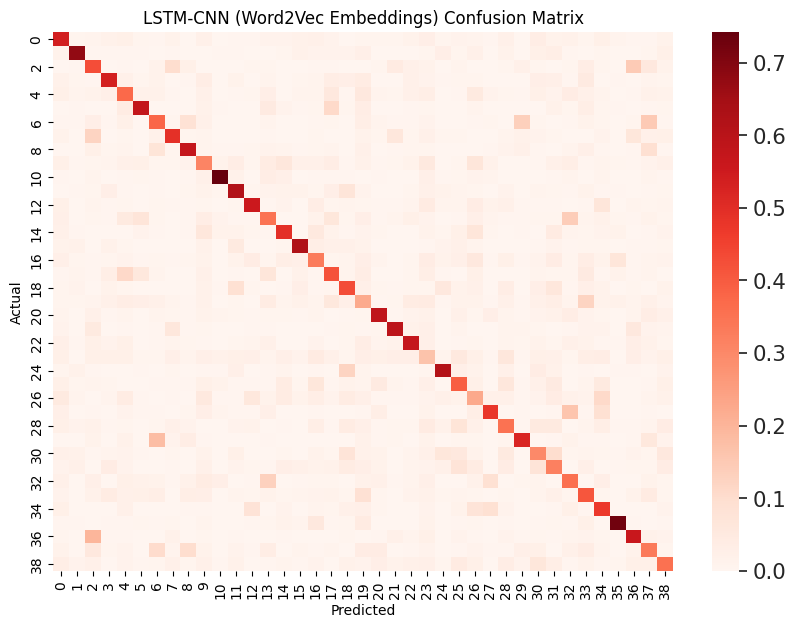

In [22]:
output_metrics(Y_pred, Y_test, normalize_cm=True, title_cm='LSTM-CNN (Word2Vec Embeddings) Confusion Matrix')